# Environment Setup

In [ ]:
!pip install pyspark==3.0.1 py4j==0.10.9 

     |████████████████████████████████| 204.2MB 91kB/s 
     |████████████████████████████████| 204kB 23.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=1e09689bb531ee39777d99c5c88b007d217243171e1f026ff5266f066d373c26
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


# Download Data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data

--2021-07-01 06:54:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [application/x-httpd-php]
Saving to: ‘abalone.data’

abalone.data        100%[===================>] 187.38K   308KB/s    in 0.6s    

2021-07-01 06:54:06 (308 KB/s) - ‘abalone.data’ saved [191873/191873]



# Task

<center><img  src="https://images.thefishsite.com/fish/articles/Australasia/green-abalone.jpg" width=700/></center>

The task for the project is to take **Abalone Dataset**, perofrm Singular Value Decompsition on Spark Clsuter and Visualize the result in reduced dimension.

## Spark Session

In [ ]:
# Starting Spark Session

from pyspark.sql import SparkSession
from pyspark import SparkConf

In [ ]:
config = {
    "spark.kubernetes.namespace": "spark",
    "spark.kubernetes.container.image": "itayb/spark:3.1.1-hadoop-3.2.0-aws",
    "spark.executor.instances": "2",
    "spark.executor.memory": "512m",
    "spark.executor.cores": "1",
    "spark.driver.blockManager.port": "36782",
    "spark.driver.port": "35472",
    "spark.driver.host": "jupyter.spark.svc.cluster.local",
    "spark.driver.bindAddress": "0.0.0.0",
    "spark.hadoop.fs.s3a.endpoint": "localstack.kube-system.svc.cluster.local:35716",
    "spark.hadoop.fs.s3a.connection.ssl.enabled": "false",
    "spark.hadoop.fs.s3a.path.style.access": "true",
    "spark.hadoop.fs.s3a.impl": "org.apache.hadoop.fs.s3a.S3AFileSystem",
    "spark.hadoop.fs.s3a.access.key": "ayush",
    "spark.hadoop.fs.s3a.secret.key": "ayush",
    "spark.hadoop.com.amazonaws.services.s3.enableV4": "true",
}

In [ ]:
def get_spark_session(app_name: str, master: string):
    conf = SparkConf()
    conf.setMaster(master)
    for key, value in config.items():
        conf.set(key, value)    
    return SparkSession.builder.appName(app_name).config(conf=conf).getOrCreate()

In [ ]:
try:
    spark = get_spark_session("SVD-on-Spark", "k8s://https://kubernetes.default.svc.cluster.local")
except:
    spark = SparkSession.builder\
            .master("local[*]")\
            .appName('SVD-on-Spark')\
            .getOrCreate()

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit, when, min, max, avg
from pyspark.sql import Window
from pyspark.sql import functions as f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [ ]:
# DEfining table Schema Manually

data_schema = [
               StructField('Sex', StringType(), True),
               StructField('Length', DoubleType(), True),
               StructField('Diameter', DoubleType(), True),
               StructField('Height', DoubleType(), True),
               StructField('Whole_weight', DoubleType(), True),
               StructField('Shucked_weight', DoubleType(), True),
               StructField('Viscera_weight', DoubleType(), True),
               StructField('Shell_weight', DoubleType(), True),
               StructField('Rings', IntegerType(), True)
            ]

In [ ]:
# Loading data in Spark environemnt.

final_struc = StructType(fields = data_schema)

try:
    data = spark.read.csv(
                          's3://abalone.data',
                          sep = ',',
                          header = True,
                          schema = final_struc 
)
    
except:
    data = spark.read.csv(
                          'abalone.data',
                          sep = ',',
                          header = True,
                          schema = final_struc 
)

data.printSchema()

root
 |-- Sex: string (nullable = true)
 |-- Length: double (nullable = true)
 |-- Diameter: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Whole_weight: double (nullable = true)
 |-- Shucked_weight: double (nullable = true)
 |-- Viscera_weight: double (nullable = true)
 |-- Shell_weight: double (nullable = true)
 |-- Rings: integer (nullable = true)



In [ ]:
# Data Subset

data.show(5)

+---+------+--------+------+------------+--------------+--------------+------------+-----+
|Sex|Length|Diameter|Height|Whole_weight|Shucked_weight|Viscera_weight|Shell_weight|Rings|
+---+------+--------+------+------------+--------------+--------------+------------+-----+
|  M|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|    7|
|  F|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|    9|
|  M|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|   10|
|  I|  0.33|   0.255|  0.08|       0.205|        0.0895|        0.0395|       0.055|    7|
|  I| 0.425|     0.3| 0.095|      0.3515|         0.141|        0.0775|        0.12|    8|
+---+------+--------+------+------------+--------------+--------------+------------+-----+
only showing top 5 rows



In [ ]:
# Count of Entries in Dataset

data.count()

4176

In [ ]:
# Summary Statistics

data.describe().show()

+-------+----+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-----------------+
|summary| Sex|            Length|           Diameter|             Height|      Whole_weight|     Shucked_weight|     Viscera_weight|       Shell_weight|            Rings|
+-------+----+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-----------------+
|  count|4176|              4176|               4176|               4176|              4176|               4176|               4176|               4176|             4176|
|   mean|null|0.5240086206896557|0.40789152298850717|0.13952705938697216|0.8288175287356346| 0.3593997844827576|0.18061266762452136|0.23885213122605353|9.932471264367816|
| stddev|null|0.1201025466927038|0.09924953111992146|0.04182639038077335|0.4904235478411498|0.22197971440458067|0.10962045433929166| 0.1392125497

## Singualar Value Decomposition

In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [ ]:
# Seprating Categoerical and Numerical Data

Y = data.select("Sex")
X = data.select(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'])

In [ ]:
# Converting Dataframe into RDD

data_matrix = RowMatrix(X.rdd.map(list))

In [ ]:
# Performing Singlular Value decomposition

svd = data_matrix.computeSVD(len(X.columns), computeU=True)

U = svd.U
sigma = svd.s
V = svd.V

## Visualization

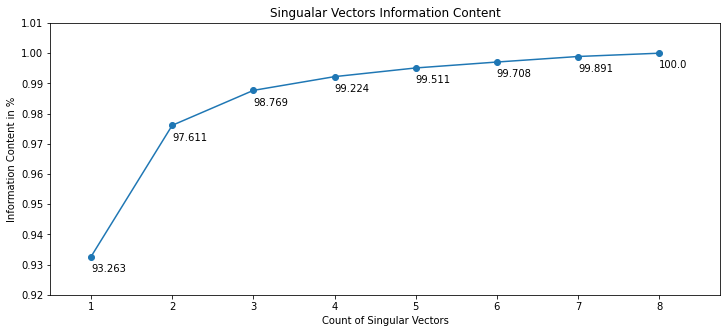

In [ ]:
# Cummualtive Sum of Contribution of Each Singular Vectors

csum = np.cumsum(sigma)/sigma.sum()

plt.figure(figsize=(12, 5))
plt.plot(range(1, len(sigma)+1), csum)
plt.scatter(range(1, len(sigma)+1), csum)
plt.xlabel("Count of Singular Vectors")
plt.ylabel("Information Content in %")
for i, val in enumerate(csum):
    plt.annotate(np.round(100*val,3), [i+1, val-0.005])
plt.ylim(0.92, 1.01)
plt.xlim(0.5, 8.75)
plt.title("Singualar Vectors Information Content")
plt.show()

In [ ]:
# Collect first two Singualr Vectors

Xs1 = np.array(U.rows.map(lambda x: x[0]).collect())
Xs2 = np.array(U.rows.map(lambda x: x[1]).collect())

In [ ]:
color_dict = {"M": "red", "F": "green", "I": "dodgerblue"}
name_dict =  {"M": "Male", "F": "Female", "I": "Infant"}

In [ ]:
# Fetching Sex attrubute for each data point.

Y_dense = np.array(list(map(lambda x: x["Sex"], Y.collect())))

In [ ]:
# Colour Allocation to each Sex.

color = np.array(list(map(lambda x: color_dict[x["Sex"]], Y.collect())))

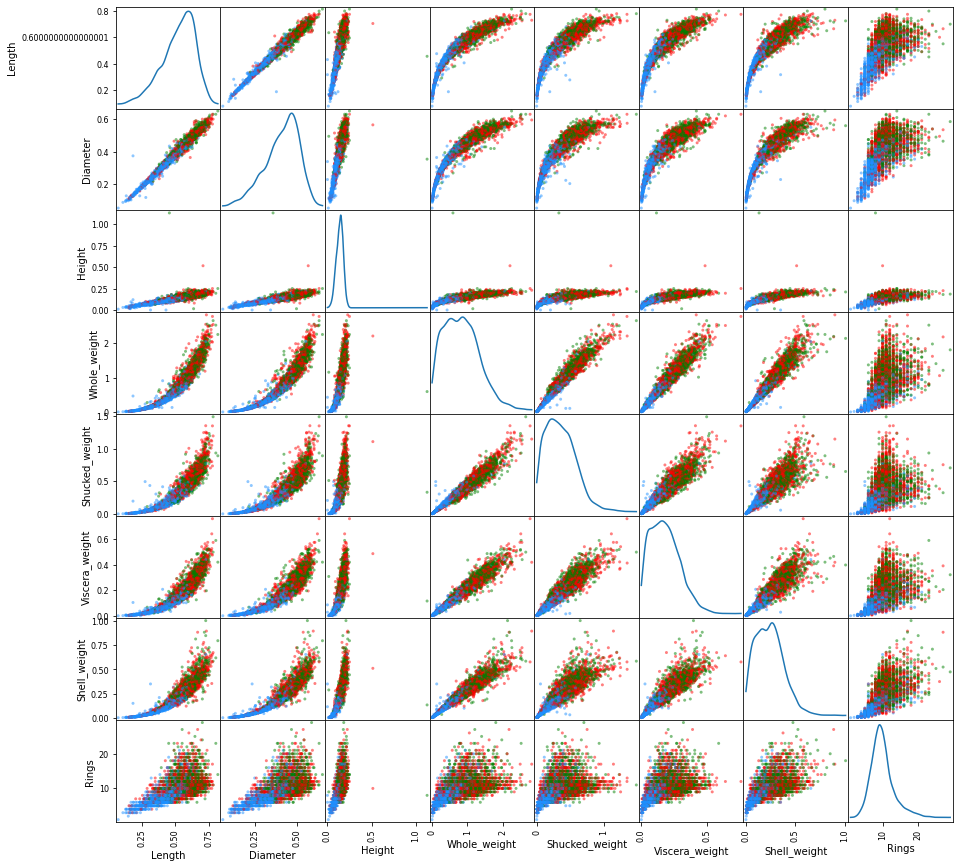

In [ ]:
# Original Data Visualization

pd.plotting.scatter_matrix(X.toPandas(), figsize=(15, 15), c=color, diagonal='kde')
plt.show()

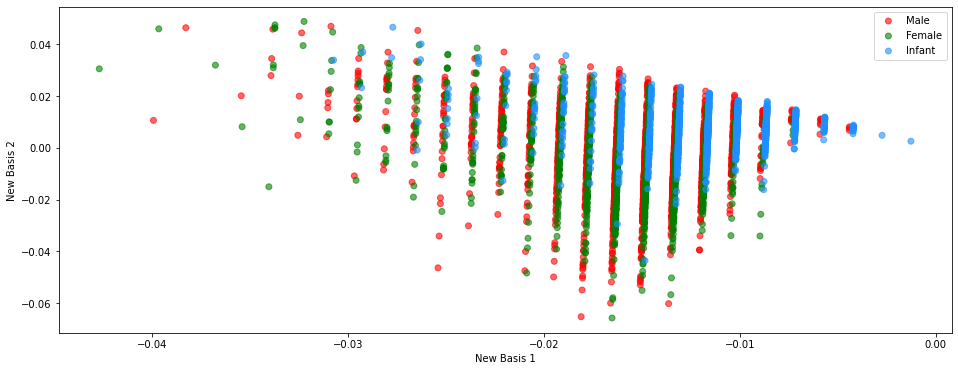

In [ ]:
# Data Vsualization in Transformed Space

plt.figure(figsize=(16, 6))
jitter = 0

for key in color_dict.keys():
    idx = (Y_dense == key)
    plt.scatter(Xs1[idx]+jitter, Xs2[idx], color=color[idx], label=name_dict[key], alpha=0.6)
    jitter += 0.0001
plt.xlabel("New Basis 1")
plt.ylabel("New Basis 2")
plt.legend()
plt.show()